<a href="https://colab.research.google.com/github/anshajk/ml/blob/master/model_interpretability/inference_using_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
! pip install -q shap interpret

     |████████████████████████████████| 5.2MB 4.9MB/s 
     |████████████████████████████████| 3.6MB 47.4MB/s 
     |████████████████████████████████| 1.8MB 47.2MB/s 
     |████████████████████████████████| 5.3MB 47.3MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 471kB 18.2MB/s 
     |████████████████████████████████| 276kB 48.1MB/s 
     |████████████████████████████████| 122kB 37.4MB/s 
     |████████████████████████████████| 788kB 40.3MB/s 
     |████████████████████████████████| 860kB 47.0MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 245kB 49.0MB/s 
     |████████████████████████████████| 1.0MB 42.7MB/s 
     |████████████████████████████████| 3.4MB 45.7MB/s 
     |████████████████████████████████| 194kB 48.7MB/s 
     |████████████████████████████████| 358kB 46.0MB/s 
     |████████████████████████████████| 358kB 51.8MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-t

In [4]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100)

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100)

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Examining the model coefficients

The most common way of understanding a linear model is to examine the coefficients learned for each feature. These coefficients tell us how much the model output changes when we change each of the input features:

In [6]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


While coefficents are great for telling us what will happen when we change the value of an input feature, by themselves they are not a great way to measure the overall importance of a feature. This is because the value of each coeffient depends on the scale of the input features. If for example we were to measure the age of a home in minutes instead of years, then the coeffiect for the AGE feature would become 0.0007∗365∗24∗60=367.92. Clearly the number of minutes since a house was built is not more important than the number of years, yet it’s coeffiecent value is much larger. This means that the magnitude of a coeffient is not nessecarily a good measure of a feature’s importance in a linear model.

## A more complete picture using partial dependence plots
To understand a feature’s importance in a model it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

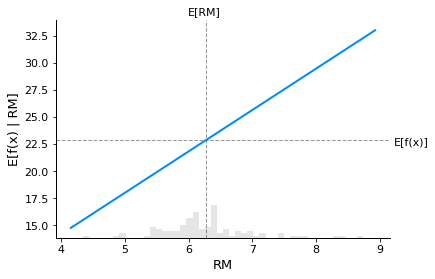

In [9]:
shap.plots.partial_dependence("RM", model.predict, X100, ice=False, model_expected_value=True, feature_expected_value=True)

The gray horizontal line in the plot above represents the expected value of the model when applied to the boston housing dataset. The vertical gray line represents the average value of the AGE feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the AGE feature to a given value) always passes through the interesection of the two gray expected value lines. We can consider this intersection point as the “center” of the partial dependence plot with respect to the data distribution. The impact of this centering will become clear when we turn to Shapley values next.

## Reading SHAP values from partial dependence plots
The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output 𝑓(𝑥) among its input features . In order to connect game theory with machine learning models it is nessecary to both match a model’s input features with players in a game, and also match the model function with the rules of the game. Since in game theory a player can join or not join a game, we need a way for a feature to “join” or “not join” a model. The most common way to define what it means for a feature to “join” a model is to say that feature has “joined a model” when we know the value of that feature, and it has not joined a model when we don’t know the value of that feature. To evaluate an existing model 𝑓 when only a subset 𝑆 of features are part of the model we integrate out the other features using a conditional expectated value formulation. This formulation can take two forms:

$$E[f(X) \mid X_S = x_S]$$
or
$$E[f(X) \mid do(X_S = x_S)]$$

In the first form we know the values of the features in S because we observe them. In the second form we know the values of the features in S because we set them. In general, the second form is usually preferable, both becuase it tells us how the model would behave if we were to intervene and change its inputs, and also because it is much easier to compute. In this tutorial we will focus entirely on the the second formulation. We will also use the more specific term SHAP values to refer to Shapley values applied to a conditional expectation function of a machine learning model.

SHAP values can be very complicated to compute (they are NP-hard in general), but linear models are so simple that we can read the SHAP values right off a partial dependence plot. When we are explaining a prediction 𝑓(𝑥), the SHAP value for a specific feature 𝑖 is just the difference between the expected model output and the partial dependence plot at the feature’s value 𝑥𝑖:

Permutation explainer: 507it [00:24, 20.83it/s]                         


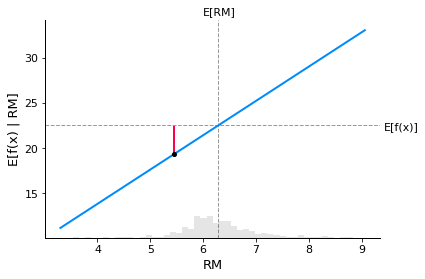

In [10]:
# compute the SHAP values for the linear model
background = shap.maskers.Independent(X, max_samples=1000)
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "RM", model.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:],
    shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
)


The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature:

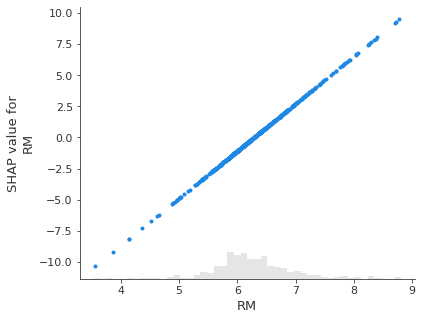

In [11]:
shap.plots.scatter(shap_values[:,"RM"])

## The additive nature of Shapley values
One the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. The easiest way to see this is through a waterfall plot that starts our background prior expectation for a home price 𝐸[𝑓(𝑋)], and then adds features one at a time until we reach the current model output 𝑓(𝑥):

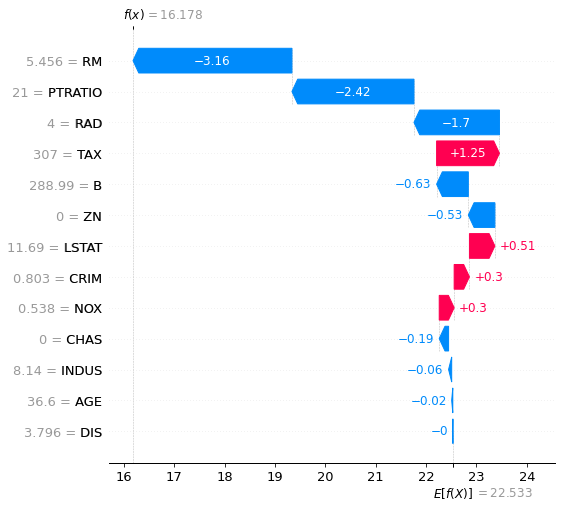

In [12]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## Explaining an additive regression model
The reason the partial dependence plots of linear models have such a close connection to SHAP values is because each feature in the model is handled independently of every other feature (the effects are just added together). We can keep this additive nature while relaxing the linear requirement of straight lines. This results in the well-known class of generalized additive models (GAMs). While there are many ways to train these types of models (like setting an XGBoost model to depth-1), we will use InterpretMLs explainable boosting machines that are specifically designed for this.

Permutation explainer: 507it [01:00,  8.36it/s]


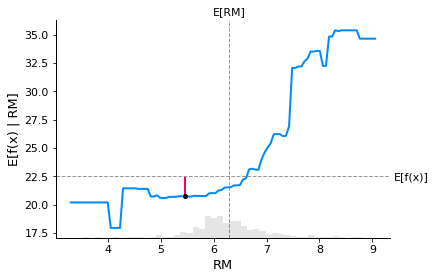

In [16]:
# fit a GAM model to the data
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, background)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:],
    shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
)